<a href="https://colab.research.google.com/github/AdicherlaVenkataSai/MLwithPython/blob/master/7.%20SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, you will use SVM (Support Vector Machines) to build and train a model using human cell records, and classify cells to whether the samples are benign or malignant.

SVM works by mapping data to a high-dimensional feature space so that data points can be categorized, even when the data are not otherwise linearly separable. A separator between the categories is found, then the data is transformed in such a way that the separator could be drawn as a hyperplane. Following this, characteristics of new data can be used to predict the group to which a new record should belong.

In [1]:
# Helper libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<h2 id="load_dataset">Load the Cancer data</h2>
The example is based on a dataset that is publicly available from the UCI Machine Learning Repository (Asuncion and Newman, 2007)[http://mlearn.ics.uci.edu/MLRepository.html]. The dataset consists of several hundred human cell sample records, each of which contains the values of a set of cell characteristics. The fields in each record are:

|Field name|Description|
|--- |--- |
|ID|Clump thickness|
|Clump|Clump thickness|
|UnifSize|Uniformity of cell size|
|UnifShape|Uniformity of cell shape|
|MargAdh|Marginal adhesion|
|SingEpiSize|Single epithelial cell size|
|BareNuc|Bare nuclei|
|BlandChrom|Bland chromatin|
|NormNucl|Normal nucleoli|
|Mit|Mitoses|
|Class|Benign or malignant|

<br>
<br>

For the purposes of this example, we're using a dataset that has a relatively small number of predictors in each record. To download the data, we will use `!wget` to download it from IBM Object Storage.  
__Did you know?__ When it comes to Machine Learning, you will likely be working with large datasets. As a business, where can you host your data? IBM is offering a unique opportunity for businesses, with 10 Tb of IBM Cloud Object Storage: [Sign up now for free](http://cocl.us/ML0101EN-IBM-Offer-CC)

In [2]:
# getting the data from IBM storage
!wget -O cell_samples.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/cell_samples.csv

--2020-06-19 00:50:33--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/cell_samples.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20675 (20K) [text/csv]
Saving to: ‘cell_samples.csv’

cell_samples.csv    100%[===================>]  20.19K  --.-KB/s    in 0.02s   

2020-06-19 00:50:33 (1.29 MB/s) - ‘cell_samples.csv’ saved [20675/20675]



### load the Dataframe

In [3]:
df = pd.read_csv('cell_samples.csv')  # loaded the data into df dataframe
df.shape  # used to check the shape of the dataframe

(699, 11)

In [4]:
df.head()  # by default it provides first 5 rows, where we can have glance of the data and different attributes

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [5]:
df.head(10)

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
5,1017122,8,10,10,8,7,10,9,7,1,4
6,1018099,1,1,1,1,2,10,3,1,1,2
7,1018561,2,1,2,1,2,1,3,1,1,2
8,1033078,2,1,1,1,2,1,1,1,5,2
9,1033078,4,2,1,1,2,1,2,1,1,2


note: We need to classify the cell size either benin or malignant, in the class attribute(target) we have two different values 2 and 4 which represent two different cell sizes 

The ID field contains the patient identifiers. The characteristics of the cell samples from each patient are contained in fields Clump to Mit. The values are graded from 1 to 10, with 1 being the closest to benign.

The Class field contains the diagnosis, as confirmed by separate medical procedures, as to whether the samples are benign (value = 2) or malignant (value = 4).

Lets look at the distribution of the classes based on Clump thickness and Uniformity of cell size:

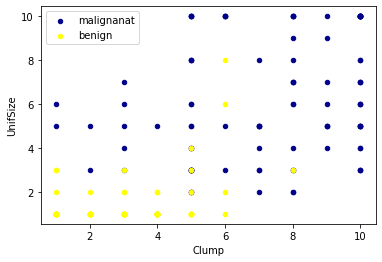

In [7]:
a = df[df['Class'] == 4][0:100].plot(kind = 'scatter', x = 'Clump',
                                    y = 'UnifSize', color = 'DarkBlue',
                                    label = 'malignanat');
df[df['Class'] == 2][0:100].plot(kind = 'scatter', x = 'Clump',
                                    y = 'UnifSize', color = 'Yellow',
                                    label = 'benign', ax = a); 
plt.show()
# we're considering the 100 samples from both of the types and scatter plotted them
# the data we see is linearly non-separable
# so we need to transform it into higer dimensions

### Data Preprocessing and selection

In [8]:
df.dtypes  # provides the data types of each attribute available in dataset

ID              int64
Clump           int64
UnifSize        int64
UnifShape       int64
MargAdh         int64
SingEpiSize     int64
BareNuc        object
BlandChrom      int64
NormNucl        int64
Mit             int64
Class           int64
dtype: object

In [9]:
# note: here all other varibles are numericals except the BareNuc
# it might contain some non numerical values

df['BareNuc'].value_counts()  # we have something like ? in 16 fields

1     402
10    132
5      30
2      30
3      28
8      21
4      19
?      16
9       9
7       8
6       4
Name: BareNuc, dtype: int64

In [12]:
df['BareNuc'].isnull().sum()  # checking for the null values

0

In [11]:
df['BareNuc'].head(50)  # lets see actual values of ?, but its the same this can be a null/nan/ 

0      1
1     10
2      2
3      4
4      1
5     10
6     10
7      1
8      1
9      1
10     1
11     1
12     3
13     3
14     9
15     1
16     1
17     1
18    10
19     1
20    10
21     7
22     1
23     ?
24     1
25     7
26     1
27     1
28     1
29     1
30     1
31     1
32     5
33     1
34     1
35     1
36     1
37     1
38    10
39     7
40     ?
41     3
42    10
43     1
44     1
45     1
46     9
47     1
48     1
49     8
Name: BareNuc, dtype: object

In [13]:
# so lets avoid using them, we drop these rows
df = df[pd.to_numeric(df['BareNuc'], errors = 'coerce').notnull()]
df['BareNuc'] = df['BareNuc'].astype('int')  # chaning the datatype to int as most are numericals
df.dtypes

ID             int64
Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int64
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int64
dtype: object

In [16]:
features = df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']]
# Making feature set, based on this we predict the class of the cell 
x = np.asarray(features)
x[0:10]

array([[ 5,  1,  1,  1,  2,  1,  3,  1,  1],
       [ 5,  4,  4,  5,  7, 10,  3,  2,  1],
       [ 3,  1,  1,  1,  2,  2,  3,  1,  1],
       [ 6,  8,  8,  1,  3,  4,  3,  7,  1],
       [ 4,  1,  1,  3,  2,  1,  3,  1,  1],
       [ 8, 10, 10,  8,  7, 10,  9,  7,  1],
       [ 1,  1,  1,  1,  2, 10,  3,  1,  1],
       [ 2,  1,  2,  1,  2,  1,  3,  1,  1],
       [ 2,  1,  1,  1,  2,  1,  1,  1,  5],
       [ 4,  2,  1,  1,  2,  1,  2,  1,  1]])

We want the model to predict the value of Class (that is, benign (=2) or malignant (=4)). As this field can have one of only two possible values, we need to change its measurement level to reflect this.

In [19]:
df['Class'] = df['Class'].astype('int')  # haven't understood usage of it
y = np.asarray(df['Class'])
y[0:10]

array([2, 2, 2, 2, 2, 4, 2, 2, 2, 2])

### Train/Test dataset

In [21]:
# we'll split the data using train_test_split() which is availabel from sklearn

from sklearn.model_selection import train_test_split as tts  # aliasing as tts
x_train, x_test, y_train, y_test = tts(x, y, test_size = 0.2, random_state = 50) 
# we're splitting at 80:20 ratio(test_size = 0.2), 
# and random_state is set such that for the multiple execution of this line will result in same split

x_train.shape, x_test.shape, y_train.shape, y_test.shape  # checking the shape after the split 
# as we previously made features of 9 attributes with one class attribute for y, hence the dimensions matches

((546, 9), (137, 9), (546,), (137,))

# Modeling SVM
The SVM algorithm offers a choice of kernel functions for performing its processing. Basically, mapping data into a higher dimensional space is called kernelling. The mathematical function used for the transformation is known as the kernel function, and can be of different types, such as:

    1.Linear
    2.Polynomial
    3.Radial basis function (RBF)
    4.Sigmoid
Each of these functions has its characteristics, its pros and cons, and its equation, but as there's no easy way of knowing which function performs best with any given dataset, we usually choose different functions in turn and compare the results. Let's just use the default, RBF (Radial Basis Function) for this lab.

In [22]:
# Here were not hard coding the SVM, instead creating an instance from the module
# already available in sklearn library

from sklearn import svm
clf = svm.SVC(kernel = 'rbf')  # svm classifier instance named as clf
clf.fit(x_train, y_train)  # we're fitting the train data to the classifier

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [23]:
# Now the model is ready to predict the new samples
yhat = clf.predict(x_test)
yhat[0:15]

array([4, 4, 2, 2, 4, 2, 4, 2, 4, 2, 2, 4, 4, 4, 4])

after the training the svm classifiebar instance, we have predcited the data and we have obtainded these values

### Evaluation

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           2       0.99      0.99      0.99        85
           4       0.98      0.98      0.98        52

    accuracy                           0.99       137
   macro avg       0.98      0.98      0.98       137
weighted avg       0.99      0.99      0.99       137

Confusion matrix, without normalization
[[84  1]
 [ 1 51]]


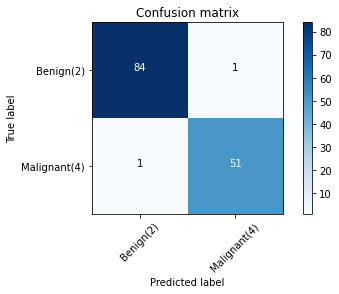

In [29]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[2,4])  # passing the argumets to the previously defined function
np.set_printoptions(precision=2)  
print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Benign(2)','Malignant(4)'],normalize= False,  title='Confusion matrix')

In [30]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted') 

0.9854014598540146

In [31]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, yhat)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


0.9854014598540146

### Practice
Can you rebuild the model, but this time with a __linear__ kernel? You can use __kernel='linear'__ option, when you define the svm. How the accuracy changes with the new kernel function?

`clf2 = svm.SVC(kernel='linear')
clf2.fit(X_train, y_train) 
yhat2 = clf2.predict(X_test)
print("Avg F1-score: %.4f" % f1_score(y_test, yhat2, average='weighted'))
print("Jaccard score: %.4f" % jaccard_similarity_score(y_test, yhat2))`